Total passengers: 4078
Avg original wait: 18.50 min
total new wait:      36113.00 min
Avg new wait:      8.86 min
Avg reduction:     9.64 min
Total original passenger-min: 75425
Total new passenger-min:      36113.0
Total saved passenger-min:    39312.0
Saved hours: 655.2, days: 27.3
Connections improved / same / worse: 95 / 21 / 0


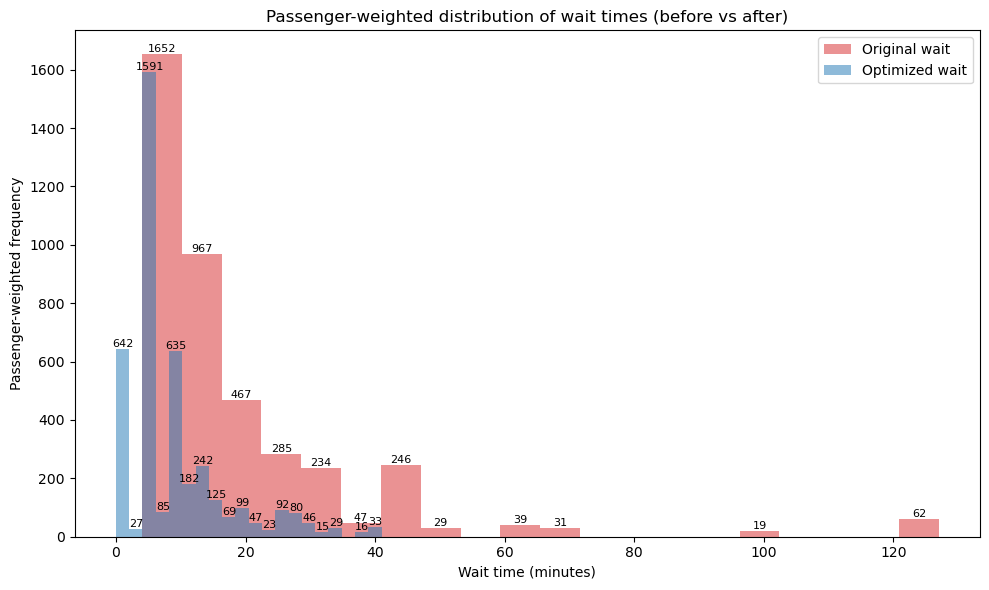

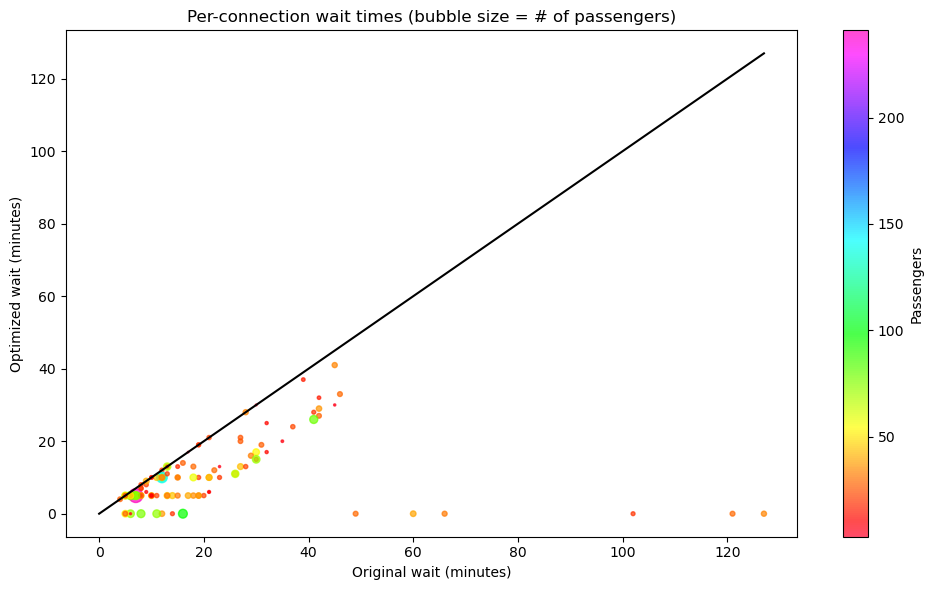

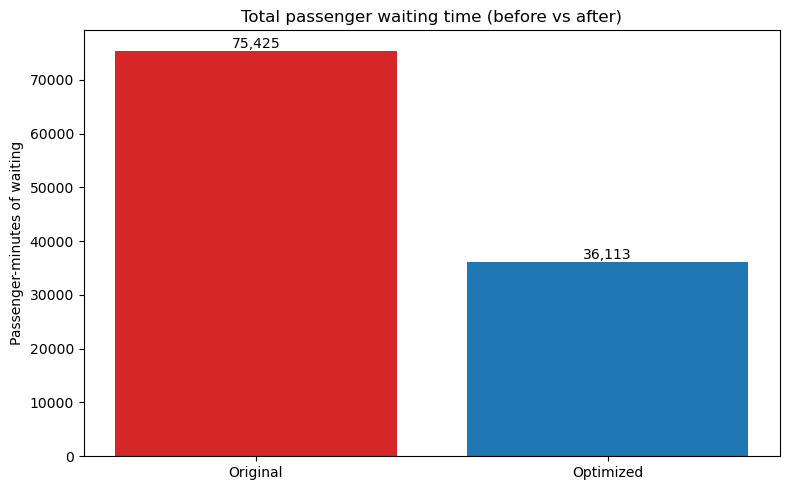

/var/folders/1g/1mkqkydx75976rvcbl376tfw0000gn/T/ipykernel_72985/2385413486.py:251: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


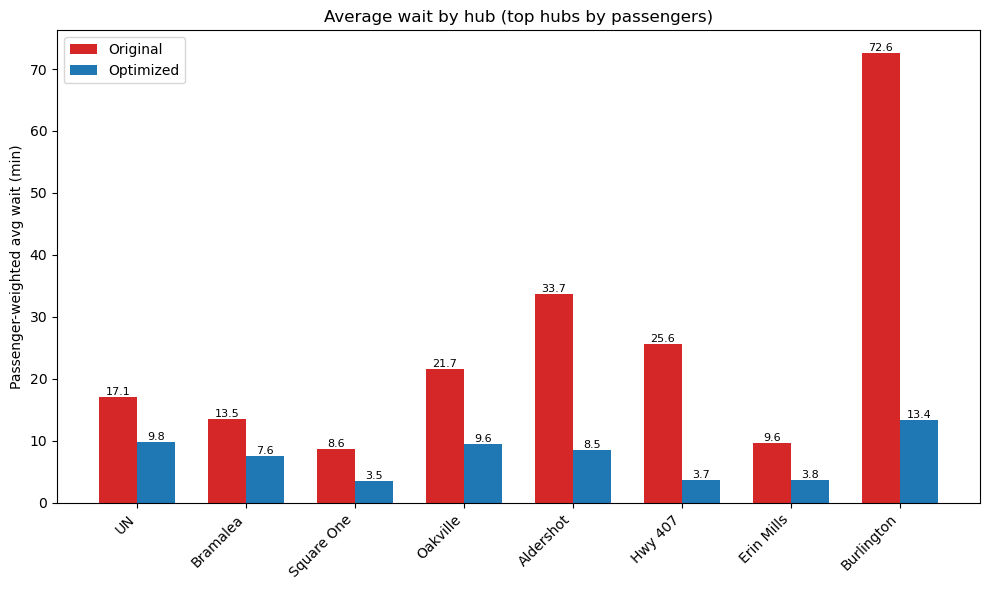

=== Hub stats (top by passengers) ===
           Hub  passengers  avg_orig_wait  avg_new_wait  saved_pm
39          UN      1146.0      17.134380      9.836824    8363.0
2     Bramalea       413.0      13.491525      7.552058    2453.0
37  Square One       316.0       8.632911      3.481013    1628.0
31    Oakville       145.0      21.655172      9.551724    1755.0
0    Aldershot       124.0      33.733871      8.467742    3133.0
20     Hwy 407       120.0      25.633333      3.708333    2631.0
10  Erin Mills       112.0       9.625000      3.750000     658.0
5   Burlington       101.0      72.613861     13.396040    5981.0

Most popular hub by (sum of weight): UN
Total weight there: 1146

=== Focus hubs (UN + most popular/second most popular) ===
     Hub  Passengers  Avg_orig_wait_min  Avg_new_wait_min  Avg_reduction_min  Saved_passenger_min  Saved_passenger_hours  Passenger_weighted_avg_total_shift_min  Connections_optimized
      UN        1146          17.134380          9.836824 

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


OPT_PATH = "optimized_schedule_results.csv"
ORIG_PATH = "All-connections.csv"

opt = pd.read_csv(OPT_PATH)
orig = pd.read_csv(ORIG_PATH)


opt["wait_change"] = opt["Orig_Wait"] - opt["New_Wait"]
opt["total_shift"] = opt["Arr_Shift"].abs() + opt["Dep_Shift"].abs()

total_new = (opt["New_Wait"] * opt["Passengers"]).sum()
# average wait time
total_pax = orig["weight"].sum()
avg_orig_wait = (opt["Orig_Wait"] * opt["Passengers"]).sum() / total_pax
avg_new_wait = (opt["New_Wait"] * opt["Passengers"]).sum() / total_pax

total_orig_pm = (opt["Orig_Wait"] * opt["Passengers"]).sum()
total_new_pm = (opt["New_Wait"] * opt["Passengers"]).sum()
total_saved_pm = total_orig_pm - total_new_pm

improved_count = (opt["wait_change"] > 0).sum()
same_count = (opt["wait_change"] == 0).sum()
worse_count = (opt["wait_change"] < 0).sum()

print(f"Total passengers: {total_pax}")
print(f"Avg original wait: {avg_orig_wait:.2f} min")
print(f"total new wait:      {total_new:.2f} min")
print(f"Avg new wait:      {avg_new_wait:.2f} min")
print(f"Avg reduction:     {avg_orig_wait - avg_new_wait:.2f} min")
print(f"Total original passenger-min: {total_orig_pm}")
print(f"Total new passenger-min:      {total_new_pm}")
print(f"Total saved passenger-min:    {total_saved_pm}")
print(f"Saved hours: {total_saved_pm/60:.1f}, days: {total_saved_pm/60/24:.1f}")
print(f"Connections improved / same / worse: {improved_count} / {same_count} / {worse_count}")

# =============================================================================
# digram 1: histograms of wait times
# =============================================================================
plt.figure(figsize=(10, 6))
bins = 20

# plt.hist(
#     opt["Orig_Wait"],
#     bins=bins,
#     weights=opt["Passengers"],
#     alpha=0.5,
#     color="tab:red",
#     label="Original wait",
# )
# plt.hist(
#     opt["New_Wait"],
#     bins=bins,
#     weights=opt["Passengers"],
#     alpha=0.5,
#     color="tab:blue",
#     label="Optimized wait",
# )
n1, bin_edges, patches1 = plt.hist(
    opt["Orig_Wait"],
    bins=bins,
    weights=opt["Passengers"],
    alpha=0.5,
    color="tab:red",
    label="Original wait"
)

n2, _, patches2 = plt.hist(
    opt["New_Wait"],
    bins=bins,
    weights=opt["Passengers"],
    alpha=0.5,
    color="tab:blue",
    label="Optimized wait"
)

# n1, bins, _ = plt.hist(
#     opt["Orig_Wait"],
#     bins=20,
#     weights=opt["Passengers"],
#     alpha=0.5,
#     label="Original wait",
#     color="tab:red",
#     histtype='stepfilled',
#     edgecolor='black'
# )

# n2, _, _ = plt.hist(
#     opt["New_Wait"],
#     bins=bins,
#     weights=opt["Passengers"],
#     alpha=0.5,
#     label="Optimized wait",
#     color="tab:blue",
#     histtype='stepfilled',
#     edgecolor='black'
# )

# Annotate bars for original wait
for count, patch in zip(n1, patches1):
    if count == 0:
        continue  # skip empty bins
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_height()
    plt.text(
        x,
        y,
        f"{int(round(count))}",
        ha="center",
        va="bottom",
        fontsize=8,
    )

# Annotate bars for optimized wait (slightly shifted to avoid perfect overlap)
for count, patch in zip(n2, patches2):
    if count == 0:
        continue
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_height()
    plt.text(
        x + patch.get_width() * 0.05,  # shift
        y,
        f"{int(round(count))}",
        ha="center",
        va="bottom",
        fontsize=8,
    )


plt.xlabel("Wait time (minutes)")
plt.ylabel("Passenger-weighted frequency")
plt.title("Passenger-weighted distribution of wait times (before vs after)")
plt.legend()
plt.tight_layout()
plt.savefig("histograms.png", dpi=150)
plt.show()

# =============================================================================
# digram 2: scatter of wait times
# =============================================================================
plt.figure(figsize=(10, 6))

size_scale = 100.0 / opt["Passengers"].max()
plt.scatter(
    opt["Orig_Wait"],
    opt["New_Wait"],
    s=opt["Passengers"] * size_scale,
    alpha=0.7,
    c=opt["Passengers"],
    cmap="gist_rainbow" 
)
plt.colorbar(label="Passengers")

# diagonal reference line
min_wait = min(opt["Orig_Wait"].min(), opt["New_Wait"].min())
max_wait = max(opt["Orig_Wait"].max(), opt["New_Wait"].max())
plt.plot([min_wait, max_wait], [min_wait, max_wait], color="black")

plt.xlabel("Original wait (minutes)")
plt.ylabel("Optimized wait (minutes)")
plt.title("Per-connection wait times (bubble size = # of passengers)")
plt.tight_layout()
plt.savefig("scatter.png", dpi=150)
plt.show()

# ---------------------------------------------------
# digram 3: total passenger-minutes before vs after
# ---------------------------------------------------
# plt.figure(figsize=(8, 5))
# plt.bar(["Original", "Optimized"], 
#         [total_orig_pm, total_new_pm],
#        color=["tab:red", "tab:blue"])
# plt.ylabel("Passenger-minutes of waiting")
# plt.title("Total passenger waiting time (before vs after)")
# plt.tight_layout()
# plt.savefig("histogram-total.png", dpi=150)
# plt.show()

plt.figure(figsize=(8, 5))

labels = ["Original", "Optimized"]
values = [total_orig_pm, total_new_pm]

bars = plt.bar(labels, values, color=["tab:red", "tab:blue"])

# Add numbers on top of each bar
for bar, value in zip(bars, values):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    plt.text(
        x,
        y,
        f"{value:,.0f}",
        ha="center",
        va="bottom",
        fontsize=10,
    )

plt.ylabel("Passenger-minutes of waiting")
plt.title("Total passenger waiting time (before vs after)")
plt.tight_layout()
plt.savefig("histogram-total.png", dpi=150)
plt.show()


# ---------------------------------------------------
# digram 4: per-hub average waits (top hubs by passengers)
# ---------------------------------------------------
# hub_stats = (
#     opt.groupby("Hub")
#     .apply(
#         lambda g: pd.Series(
#             {
#                 "passengers": g["Passengers"].sum(),
#                 "avg_orig_wait": (g["Orig_Wait"] * g["Passengers"]).sum()
#                 / g["Passengers"].sum(),
#                 "avg_new_wait": (g["New_Wait"] * g["Passengers"]).sum()
#                 / g["Passengers"].sum(),
#                 "saved_pm": ((g["Orig_Wait"] - g["New_Wait"]) * g["Passengers"]).sum(),
#                 "n_connections": len(g),
#             }
#         )
#     )
#     .reset_index()
# )

# top_hubs = hub_stats.sort_values("passengers", ascending=False).head(8)

# plt.figure(figsize=(10, 6))
# x = np.arange(len(top_hubs))
# width = 0.35

# plt.bar(x - width / 2, top_hubs["avg_orig_wait"], width, label="Original", color="tab:red")
# plt.bar(x + width / 2, top_hubs["avg_new_wait"], width, label="Optimized", color="tab:blue")

# plt.xticks(x, top_hubs["Hub"], rotation=45, ha="right")
# plt.ylabel("Passenger-weighted avg wait (min)")
# plt.title("Average wait by hub (top hubs by passengers)")
# plt.legend()
# plt.tight_layout()
# plt.savefig("histogram-hub.png", dpi=150)
# plt.show()


hub_stats = (
    opt.groupby("Hub")
    .apply(
        lambda g: pd.Series(
            {
                "passengers": g["Passengers"].sum(),
                "avg_orig_wait": (g["Orig_Wait"] * g["Passengers"]).sum()
                / g["Passengers"].sum(),
                "avg_new_wait": (g["New_Wait"] * g["Passengers"]).sum()
                / g["Passengers"].sum(),
                "saved_pm": ((g["Orig_Wait"] - g["New_Wait"]) * g["Passengers"]).sum(),
                "n_connections": len(g),
            }
        )
    )
    .reset_index()
)

top_hubs = hub_stats.sort_values("passengers", ascending=False).head(8)

plt.figure(figsize=(10, 6))
x = np.arange(len(top_hubs))
width = 0.35

orig_vals = top_hubs["avg_orig_wait"].values
new_vals  = top_hubs["avg_new_wait"].values

bars_orig = plt.bar(
    x - width / 2,
    orig_vals,
    width,
    label="Original",
    color="tab:red",
)
bars_new = plt.bar(
    x + width / 2,
    new_vals,
    width,
    label="Optimized",
    color="tab:blue",
)

# Add numbers on top of each bar (horizontal text)
for bar, val in zip(bars_orig, orig_vals):
    x_pos = bar.get_x() + bar.get_width() / 2
    y_pos = bar.get_height()
    plt.text(
        x_pos,
        y_pos,
        f"{val:.1f}",   # 1 decimal place
        ha="center",
        va="bottom",
        fontsize=8,
    )

for bar, val in zip(bars_new, new_vals):
    x_pos = bar.get_x() + bar.get_width() / 2
    y_pos = bar.get_height()
    plt.text(
        x_pos,
        y_pos,
        f"{val:.1f}",
        ha="center",
        va="bottom",
        fontsize=8,
    )

plt.xticks(x, top_hubs["Hub"], rotation=45, ha="right")
plt.ylabel("Passenger-weighted avg wait (min)")
plt.title("Average wait by hub (top hubs by passengers)")
plt.legend()
plt.tight_layout()
plt.savefig("histogram-hub.png", dpi=150)
plt.show()

print("=== Hub stats (top by passengers) ===")
print(top_hubs[["Hub", "passengers", "avg_orig_wait", "avg_new_wait", "saved_pm"]])
print()


hub_popularity = orig.groupby("hub_id")["weight"].sum().sort_values(ascending=False)

most_popular_hub_overall = hub_popularity.idxmax()

# If that hub isn't present in optimized results, fall back to the most popular hubs that do appear
if most_popular_hub_overall in opt["Hub"].unique():
    most_popular_hub = most_popular_hub_overall
else:
    hub_popularity_in_opt = hub_popularity[hub_popularity.index.isin(opt["Hub"].unique())]
    most_popular_hub = hub_popularity_in_opt.idxmax()

print("Most popular hub by (sum of weight):", most_popular_hub)
print("Total weight there:", hub_popularity[most_popular_hub])
print()

# Grab the second-most-popular hub
second_popular_hub = None
if most_popular_hub == "UN":
    for hub in hub_popularity.index:
        if hub != "UN" and hub in opt["Hub"].unique():
            second_popular_hub = hub
            break

focus_hubs = ["UN"]
if most_popular_hub != "UN":
    focus_hubs.append(most_popular_hub)
elif second_popular_hub is not None:
    focus_hubs.append(second_popular_hub)

focus_stats_rows = []

for hub in focus_hubs:
    g = opt[opt["Hub"] == hub]
    if g.empty:
        continue
    pax = g["Passengers"].sum()
    avg_o = (g["Orig_Wait"] * g["Passengers"]).sum() / pax
    avg_n = (g["New_Wait"] * g["Passengers"]).sum() / pax
    saved_pm = ((g["Orig_Wait"] - g["New_Wait"]) * g["Passengers"]).sum()
    avg_total_shift_pw = (g["total_shift"] * g["Passengers"]).sum() / pax

    focus_stats_rows.append(
        {
            "Hub": hub,
            "Passengers": pax,
            "Avg_orig_wait_min": avg_o,
            "Avg_new_wait_min": avg_n,
            "Avg_reduction_min": avg_o - avg_n,
            "Saved_passenger_min": saved_pm,
            "Saved_passenger_hours": saved_pm / 60.0,
            "Passenger_weighted_avg_total_shift_min": avg_total_shift_pw,
            "Connections_optimized": len(g),
        }
    )

focus_stats = pd.DataFrame(focus_stats_rows)
print("=== Focus hubs (UN + most popular/second most popular) ===")
print(focus_stats.to_string(index=False))
print()
